# Импорти и глобални параметри

In [1]:
from dask import dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.animation
from datetime import datetime
import numpy as np

plt.rcParams['font.size'] = '20'

# Импортиране на файлове

In [3]:
ddf_users = dd.read_csv('..\\data\\raw\\2022_place_canvas_history_users.csv')
ddf_users.head()

,user_id
0,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...
1,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...
2,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...
3,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...
4,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...


In [2]:
ddf_main = dd.read_csv('..\\data\\raw\\2022_place_canvas_history_optimized.csv')
ddf_main.head()

,timestamp,pixel_color,coordinate
0,0,14,"42,42"
1,12356,3,"999,999"
2,16311,7,"44,42"
3,21388,21,"2,2"
4,34094,7,"23,23"


# Работа с таблицата за потребители

In [5]:
all_users = ddf_users.user_id.value_counts().compute().reset_index(name='num')

### Стълбовидна диаграма за 20-те най-активни потребители

In [6]:
most_active_users = all_users.head(20)
most_active_users

,index,num
0,kgZoJz//JpfXgowLxOhcQlFYOCm8m6upa6Rpltcc63K6Cz...,795
1,JMlte6XKe+nnFvxcjT0hHDYYNgiDXZVOkhr6KT60EtJAGa...,781
2,LNbGhj45pAeCvBYQF1dPvwx1zVfVTy8AdRxTSHi0pR9Yea...,777
3,8USqGo14WuZQLG7PSAwqfFwICkU0G4VyHZTuV8D1QSbQHE...,767
4,K54RRTUCFuOU55RzSTkjo/ftbJqVi9miyt52YV6NlENRfU...,767
5,DspItMbX4x7ZD/Ozqke3BL3IQs40A3suoSQ8mb5V7Nu8Z1...,766
6,6QK00igvPdzUYm9SEriCDTbwTmM3RcY17Ynr9FRA6PfLKM...,765
7,VenbgVzRUq0U7MX3agINB3qBtjbEkZh8HmPSQHnkhkTwy/...,758
8,jjtKU98x1Bc/qYVoVBq/gQd6yaFiaTrb2vT6fp+Ias+Pea...,730
9,VHg2OiSkbBCDTTl1W41fdvDSJk/QtKsdsufSZomBPV3cr2...,713


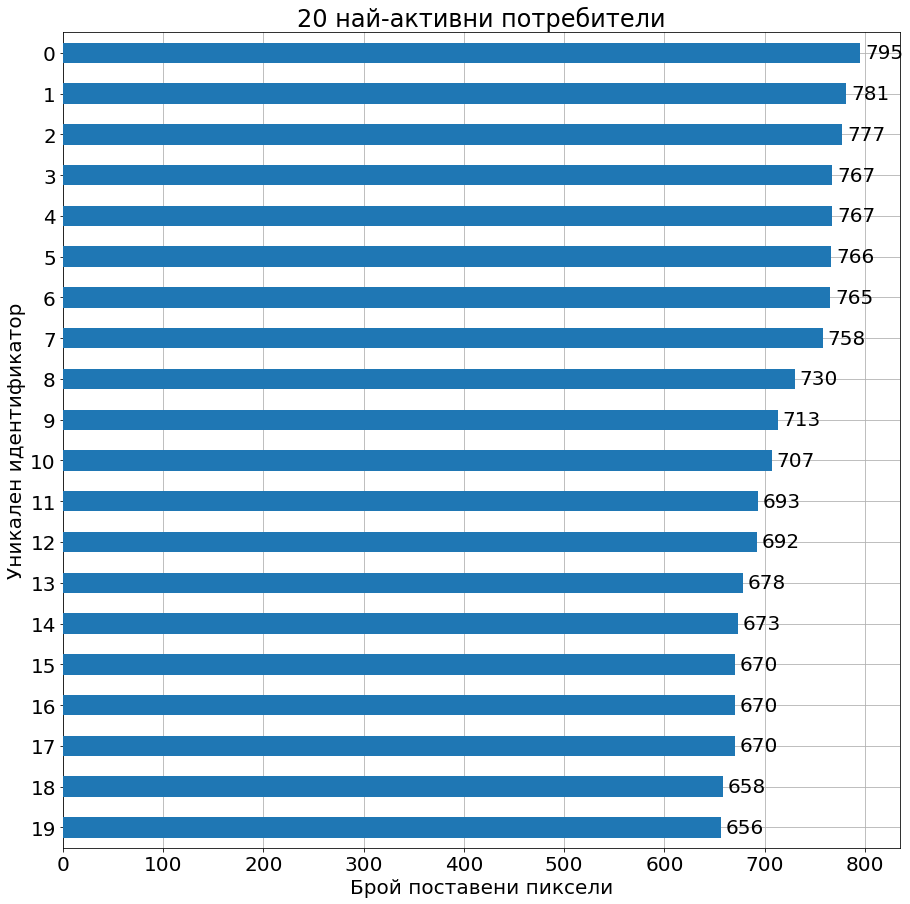

In [7]:
plot = most_active_users.plot(figsize=(15,15), kind='barh', zorder=3)
plot.set_xscale('linear')
plot.set_xlabel('Брой поставени пиксели')
plot.set_ylabel('Уникален идентификатор')
plot.set_title('20 най-активни потребители')
plot.invert_yaxis()
plot.grid(visible=True)

y_tick_labels = []
for label in plot.get_yticklabels():
    y_tick_labels.append(label.get_text()[0:15])

plot.set_yticklabels(y_tick_labels)
plot.grid(visible=True, zorder=0)

bar_labels = plot.containers[0]
plot.axes.bar_label(bar_labels, padding=5)

plot.get_legend().remove()


### Разпръсната диаграма, представяща броят потребители според броят на поставените им пиксели

In [8]:
num_active_users = all_users.num.value_counts().reset_index(name='users')
num_active_users

,index,users
0,1,2340498
1,2,1175052
2,3,768335
3,4,572021
4,5,460215
...,...,...
633,632,1
634,637,1
635,638,1
636,639,1


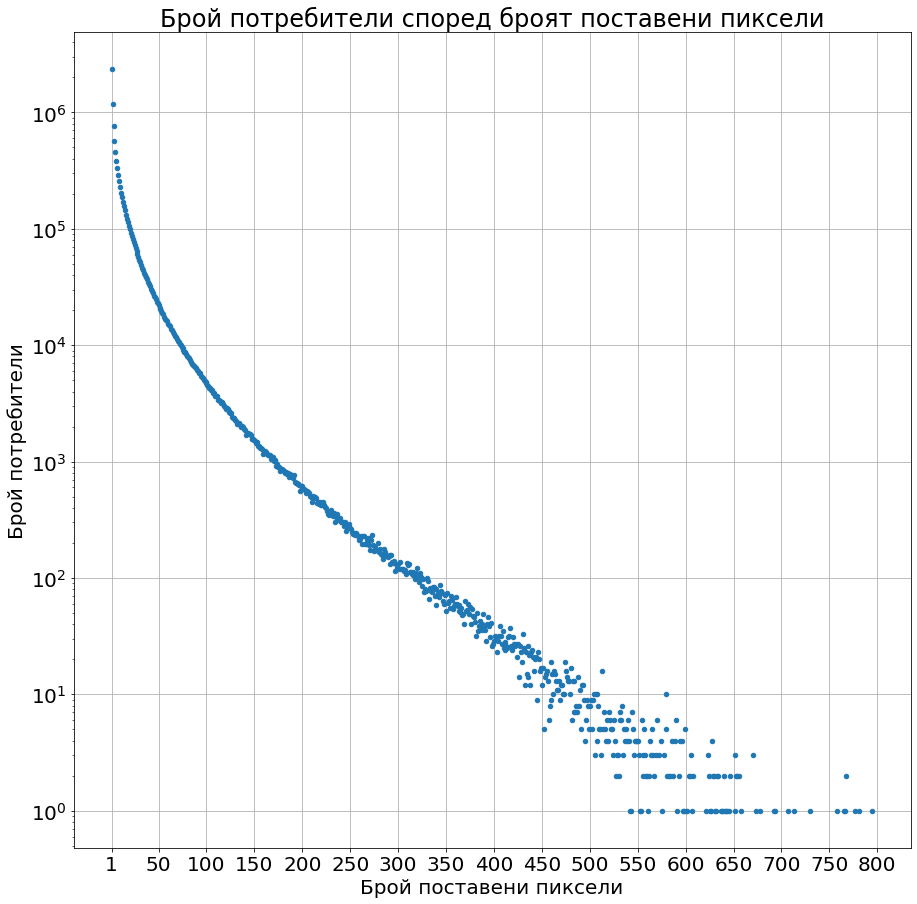

In [9]:
plot = num_active_users.plot(x=0, y=1, figsize=(15,15), kind='scatter', zorder=3)
plot.set_yscale('log')
plot.set_xscale('linear')
plot.set_xlabel('Брой поставени пиксели')
plot.set_ylabel('Брой потребители')
plot.set_title('Брой потребители според броят поставени пиксели')
plot.set_xticks([1,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800])
plot.grid(visible=True, zorder=0)

# Работа с основната информация

## Работа с информация за цветовете

In [10]:
def parse_pixel_color(pixel_color):
    key_to_hex = {
        0: ["#000000", "Черно"],
        1: ["#00756F", "Зелено"],
        2: ["#009EAA", "Синьо"],
        3: ["#00A368", "Тъмно синьо"],
        4: ["#00CC78", "Карибско зелено"],
        5: ["#00CCC0", "Циано"],
        6: ["#2450A4", "Тъмно синьо"],
        7: ["#3690EA", "Светло синьо"],
        8: ["#493AC1", "Синьо-лилаво"],
        9: ["#515252", "Сиво"],
        10: ["#51E9F4", "Тюркоазено"],
        11: ["#6A5CFF", "Светло синьо-лилаво"],
        12: ["#6D001A", "Тъмно червено"],
        13: ["#6D482F", "Кафяво"],
        14: ["#7EED56", "Светло зелено"],
        15: ["#811E9F", "Тъмно лилаво"],
        16: ["#898D90", "Светло сиво"],
        17: ["#94B3FF", "Сиво-синьо",],
        18: ["#9C6926", "Жълто-кафяво"],
        19: ["#B44AC0", "Светло лилаво"],
        20: ["#BE0039", "Червено"],
        21: ["#D4D7D9", "Сребърно"],
        22: ["#DE107F", "Тъмно розово"],
        23: ["#E4ABFF", "Лилаво-розово"],
        24: ["#FF3881", "Светло розово"],
        25: ["#FF4500", "Червено-оранжево"],
        26: ["#FF99AA", "Розово"],
        27: ["#FFA800", "Жълто-оранжево"],
        28: ["#FFB470", "Оранжево"],
        29: ["#FFD635", "Жълто"],
        30: ["#FFF8B8", "Светло жълто"],
        31: ["#FFFFFF", "Бяло"],
    }
    return key_to_hex[pixel_color]

### Диаграма, представяща броят поставени пиксели от всеки цвят

In [11]:
most_used_colors = ddf_main.pixel_color.value_counts().compute()
most_used_colors

0     33707371
31    32251013
25    14411389
6      9989854
29     8519392
20     5911641
10     5700301
15     5245484
27     5059970
26     4917801
7      4058046
3      3892844
16     3459390
14     3417232
21     3324082
18     2473639
28     2104848
24     1458772
19     1287672
13     1261416
4      1200067
8      1139350
30      954606
9       868769
12      621194
22      589211
1       572572
11      499233
17      454142
2       436068
23      350873
5       214862
Name: pixel_color, dtype: int64

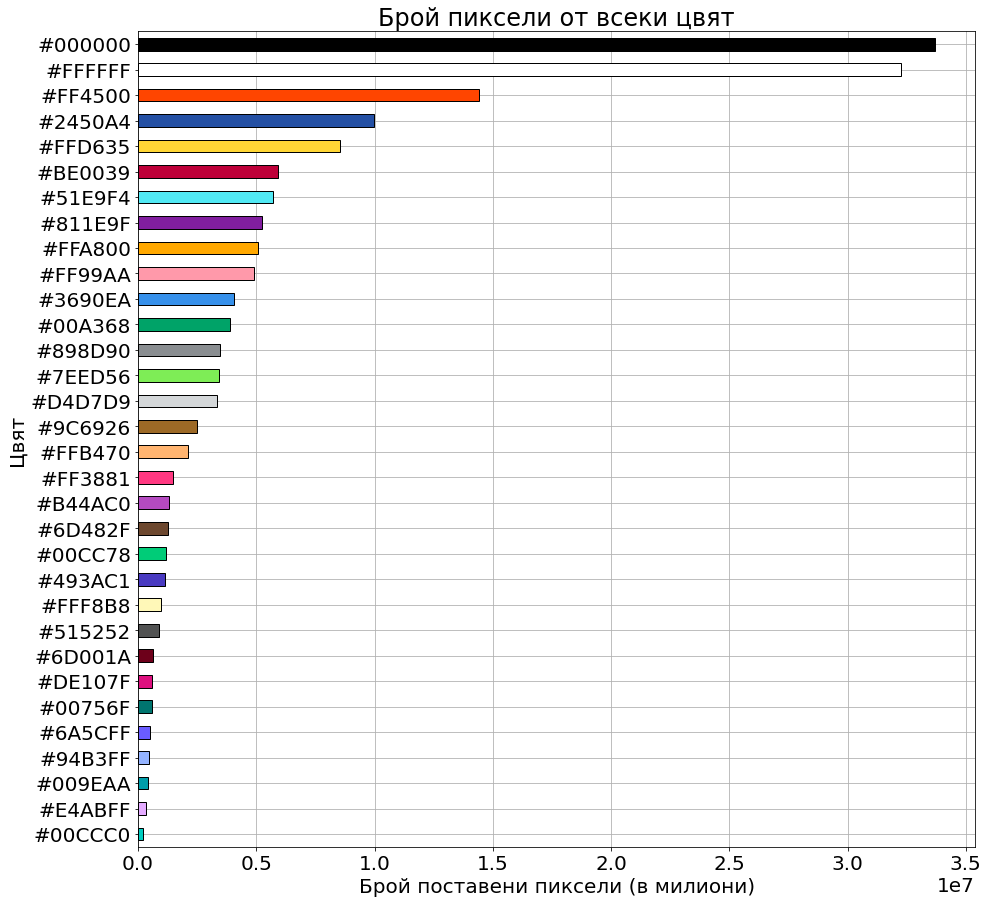

In [12]:
colors = []
for color_num in most_used_colors.iteritems():
    colors.append(parse_pixel_color(color_num[0])[0])

colors_names = []
for color_hex in most_used_colors.iteritems():
    colors_names.append(parse_pixel_color(color_hex[0])[0])
    
plot = most_used_colors.plot(figsize=(15,15), kind='barh', color=colors, edgecolor='black', zorder=3)
plot.set_xscale('linear')
plot.set_xlabel('Брой поставени пиксели (в милиони)')
plot.set_ylabel('Цвят')
plot.set_title('Брой пиксели от всеки цвят')
plot.set_yticklabels(colors_names)
plot.invert_yaxis()
plot.grid(visible=True, zorder=0)

## Работа с информацията за координатите

In [13]:
active_spots = ddf_main.coordinate.value_counts().compute()

### Диаграма, преставяща 20-те най-често променяни точки

In [14]:
top_active_spots = active_spots.head(20)
top_active_spots

0,0          98807
359,564      69198
349,564      55230
859,766      52261
860,766      51485
104,768      38086
105,768      34082
1999,1999    31437
1999,0       30882
633,728      30752
1058,756     29295
1999,999     26928
999,999      23271
0,1999       22763
420,420      22365
0,999        22358
780,888      22164
299,372      21183
1059,756     19778
1890,353     19383
Name: coordinate, dtype: int64

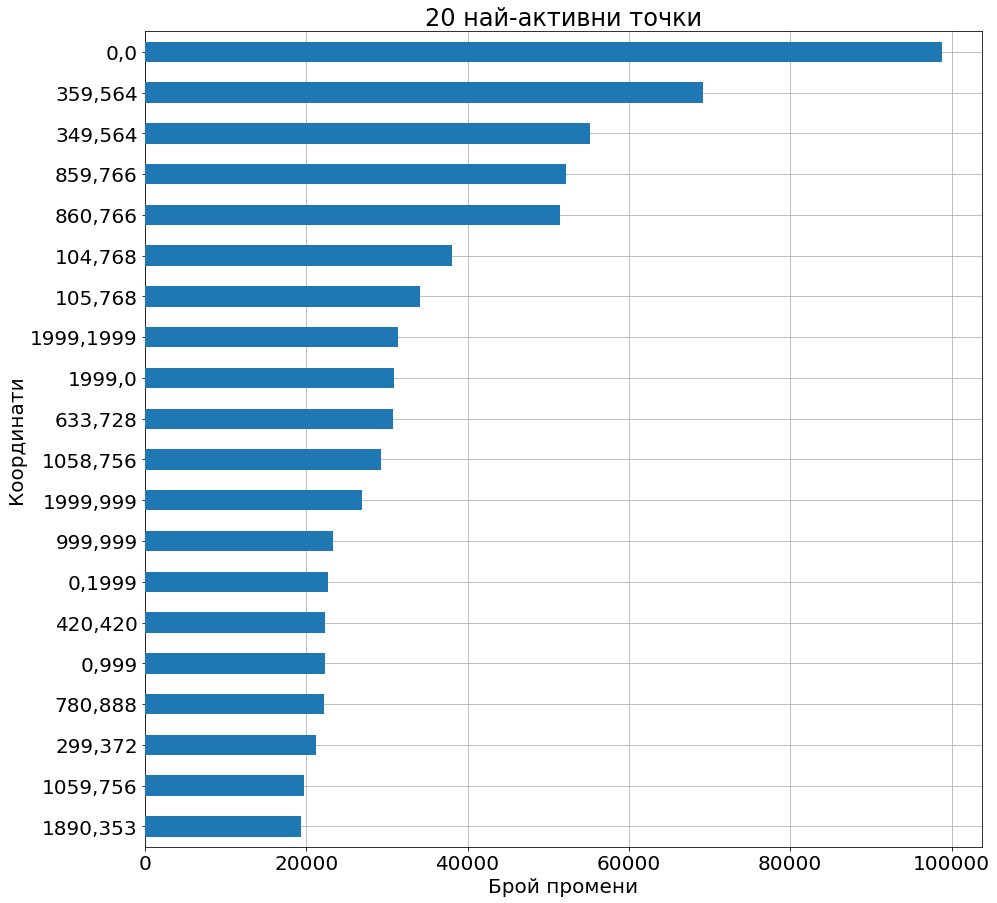

In [15]:
plot = top_active_spots.plot(figsize=(15,15), kind='barh', zorder=3)
plot.set_xscale('linear')
plot.set_xlabel('Брой промени')
plot.set_ylabel('Координати')
plot.set_title('20 най-активни точки')
plot.invert_yaxis()
plot.grid(visible=True, zorder=0)


## Работа с информацията за времето

In [3]:
def parse_timestamp(timestamp):
    date_format = '%Y-%m-%d %H:%M'

    timestamp /= 1000
    timestamp = int(timestamp)
    timestamp += 1648806250

    dt = datetime.fromtimestamp(timestamp).strftime(date_format)
    dt = datetime.strptime(dt, date_format)

    return dt

In [4]:
ddf_modified = ddf_main.copy()
ddf_modified.head()

,timestamp,pixel_color,coordinate
0,0,14,"42,42"
1,12356,3,"999,999"
2,16311,7,"44,42"
3,21388,21,"2,2"
4,34094,7,"23,23"


In [5]:
ddf_modified['datetime'] = ddf_modified['timestamp'].map(parse_timestamp)
ddf_modified = ddf_modified.drop(['timestamp', 'pixel_color', 'coordinate'], axis=1)
ddf_modified.head()

,datetime
0,2022-04-01 12:44:00
1,2022-04-01 12:44:00
2,2022-04-01 12:44:00
3,2022-04-01 12:44:00
4,2022-04-01 12:44:00


In [6]:
ddf_date = ddf_modified.datetime.value_counts('datetime').compute()

In [10]:
ddf_date = ddf_date.reset_index(name='num_placed_pixels')

In [11]:
ddf_modified = ddf_modified.merge(ddf_date, 'left')
ddf_modified.head()

,datetime,index,num_placed_pixels
0,2022-04-01 12:44:00,2022-04-04 21:47:00,158655.0
1,2022-04-01 12:44:00,2022-04-03 21:00:00,156066.0
2,2022-04-01 12:44:00,2022-04-04 21:53:00,145038.0
3,2022-04-01 12:44:00,2022-04-04 21:43:00,143299.0
4,2022-04-01 12:44:00,2022-04-04 21:37:00,142261.0


In [19]:
ddf_modified['index'] = dd.to_datetime(ddf_modified['index'])
ddf_modified['datetime'] = dd.to_datetime(ddf_modified['datetime'])
ddf_modified.head()

,datetime,index,num_placed_pixels
0,2022-04-01 12:44:00,2022-04-04 21:47:00,158655.0
1,2022-04-01 12:44:00,2022-04-03 21:00:00,156066.0
2,2022-04-01 12:44:00,2022-04-04 21:53:00,145038.0
3,2022-04-01 12:44:00,2022-04-04 21:43:00,143299.0
4,2022-04-01 12:44:00,2022-04-04 21:37:00,142261.0


In [21]:
ddf_modified_sorted = ddf_modified.drop('datetime',axis=1).sort_values('index')
ddf_modified_sorted.head()

TypeError: Cannot convert NaTType to pandas._libs.tslibs.timestamps._Timestamp